1. DBSCAN noise points have label -1, so I remove all the -1 noise samples.   
Checking the PCA loading coefficients to interpret what each PC represents is indeed convenient, but in reality many small features in a PC cannot be directly linked to style. So at the moment, I can only rely on plotting the PCs and deducing what style the two ends of each PC correspond to.

2. Plot PC1 and PC2.
Use known players to judge what styles the axes correspond to + examine the main contributing features of these two axes.
I want to use Plotly here so the points are interactive and verifiable.

3. Plot PC3 and PC4.
Again, use known players to infer the styles + look at their contributing features.

4. Pseudo-labels:
Assign labels to players who are extreme on PC1/PC2, and then train multiple classifiers.

5. Feed the noise points from Step 1 (i.e., the ordinary players) into these classifiers to obtain multi-dimensional probability values.

In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
df = pd.read_csv('player_features.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2695 entries, 0 to 2694
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2695 non-null   int64  
 1   user                       2695 non-null   object 
 2   CenterControlScore         2695 non-null   float64
 3   PieceActivityScore         2695 non-null   float64
 4   KingSafetyScore            2695 non-null   float64
 5   CastlingScore              2695 non-null   float64
 6   KingTropismScore           2695 non-null   float64
 7   KingDefendersScore         2695 non-null   float64
 8   KingPawnShieldScore        2695 non-null   float64
 9   KingZoneControlScore       2695 non-null   float64
 10  KingDiagonalExposureScore  2695 non-null   float64
 11  KingEscapeSquaresScore     2695 non-null   float64
 12  CaptureRatio               2695 non-null   float64
 13  PawnCenter                 2695 non-null   float

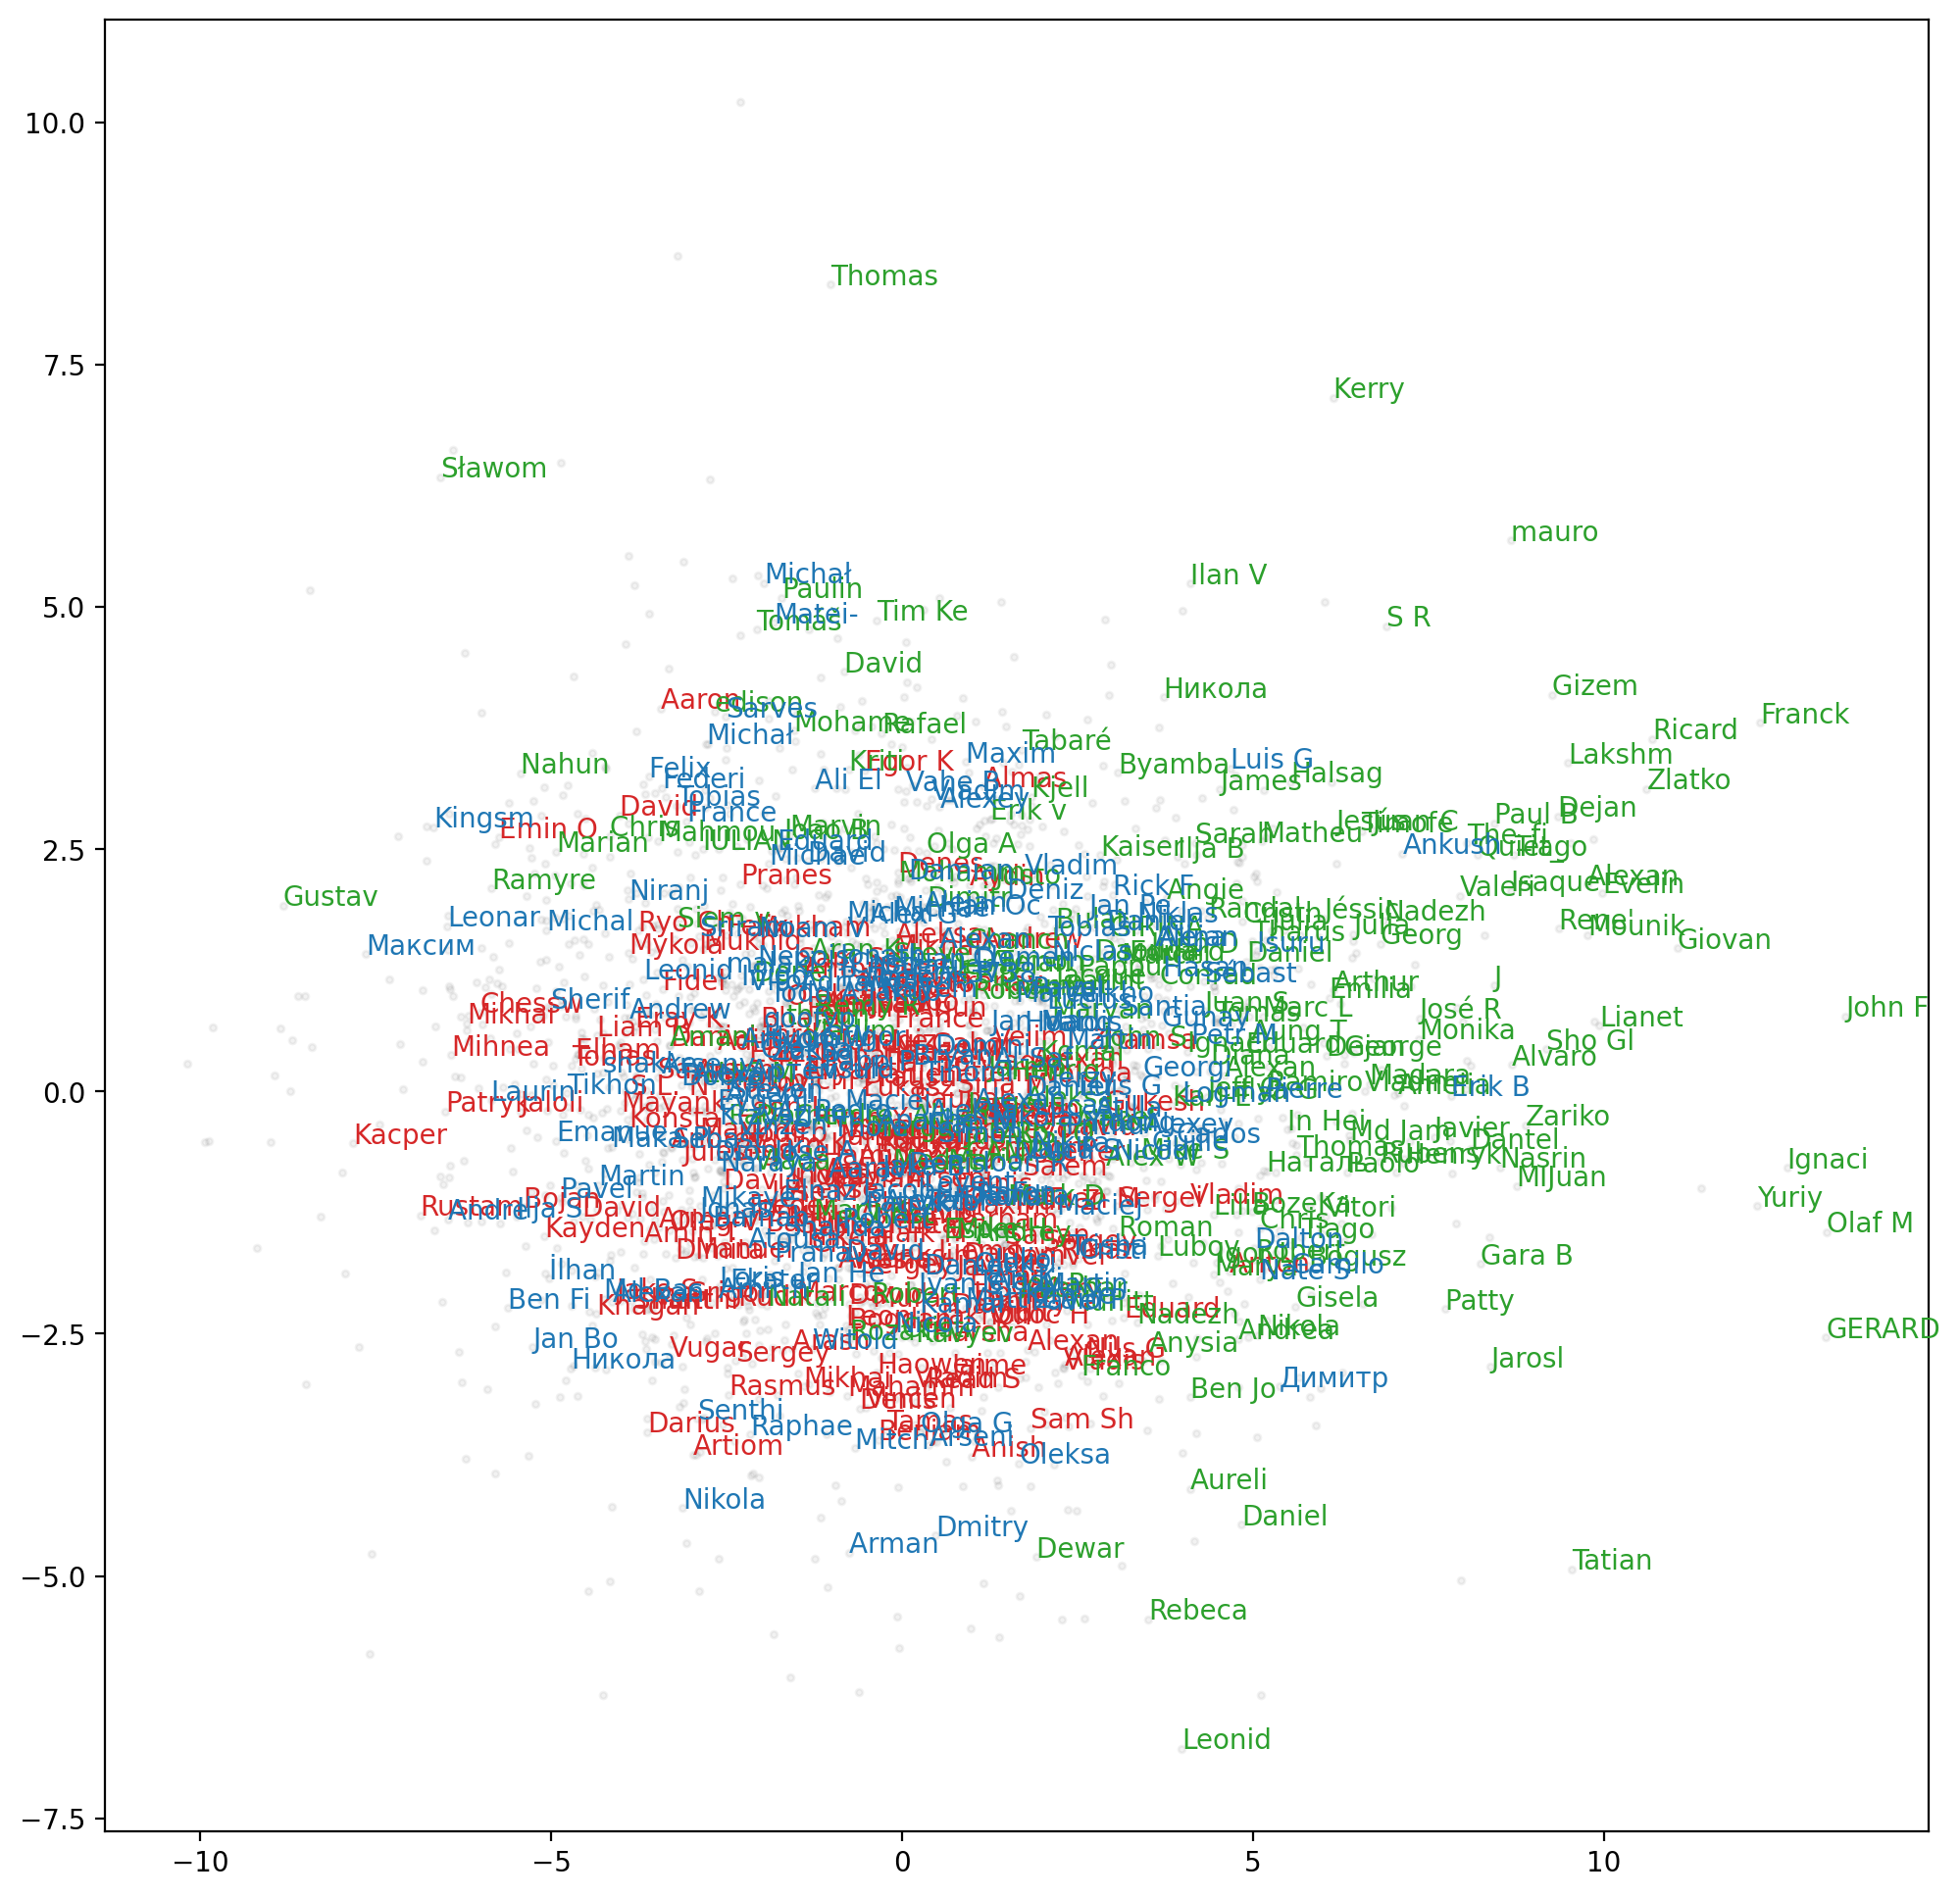

In [4]:
#把所有数字特征都扔到了pca里
cols=list(df.columns[2:20])+list(df.columns[24:47])  #除去了非皇后的升变
df_filt = df[df.TotalGames > 100][cols].fillna(0).reset_index(drop=True)
# Create the pipeline
pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10))
])

# Fit the pipeline and transform the data
X_pca = pca_pipeline.fit_transform(df_filt.values)
num_chosen = 200
lowest_players = df.sort_values(by='ELO').Name[0:num_chosen].values
highest_players = df.sort_values(by='ELO', ascending=False).Name[0:num_chosen].values
medium_players = df.sort_values(by='ELO', ascending=False).Name[int(len(df)/2):int(len(df)/2)+num_chosen].values

plt.figure(figsize=(12,12))
for name in highest_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C3')

for name in lowest_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C2')

for name in medium_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C0')


plt.plot(X_pca[:,0], X_pca[:,1], 'o', alpha=0.05, c='k', ms=2.5)

use DBSCAN to filter out the green noise part

In [5]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import numpy as np
import plotly.express as px


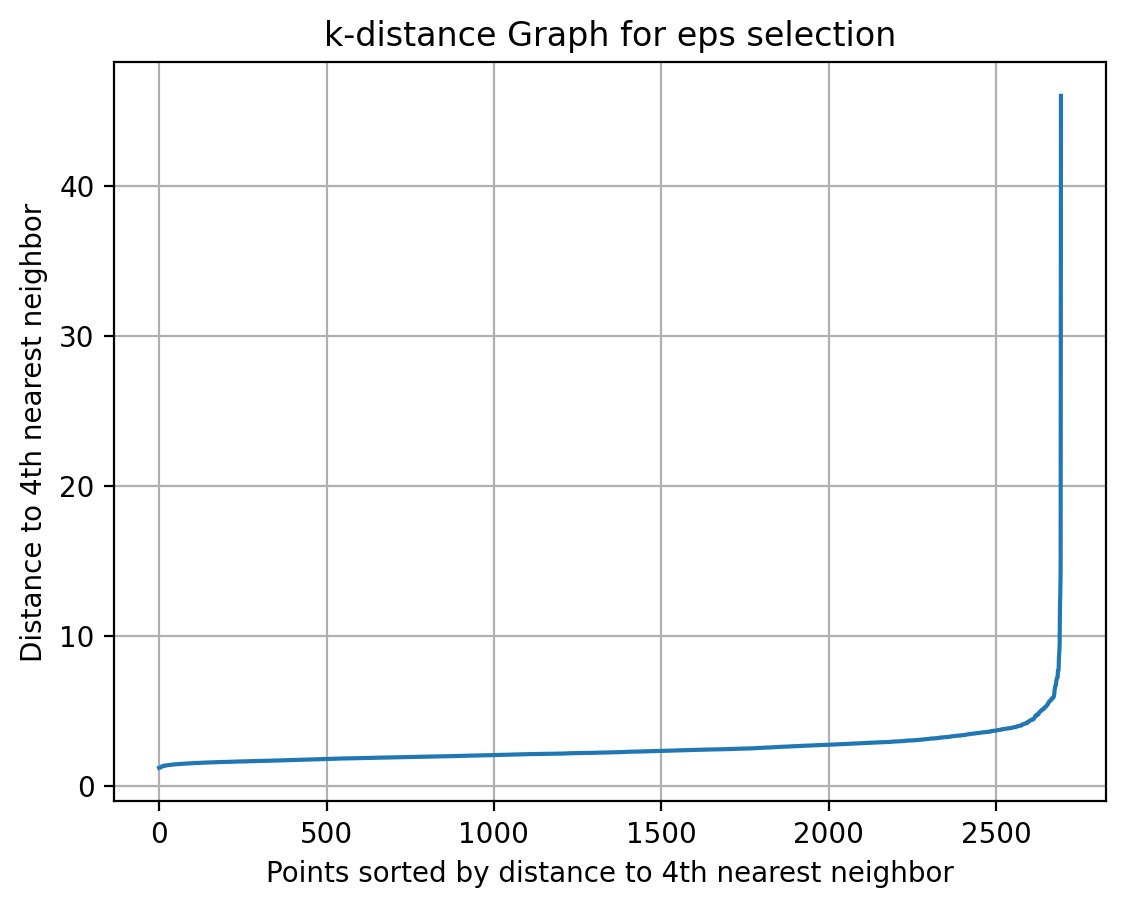

In [6]:
neighbors=NearestNeighbors(n_neighbors=20) #可能还要改
neighbors_fit=neighbors.fit(X_pca)
distance,indices=neighbors_fit.kneighbors(X_pca)
distance=np.sort(distance[:,3])
plt.plot(distance)
plt.xlabel('Points sorted by distance to 4th nearest neighbor')
plt.ylabel('Distance to 4th nearest neighbor')
plt.title('k-distance Graph for eps selection')
plt.grid(True)
plt.show()
#eps选择大概0.5这样

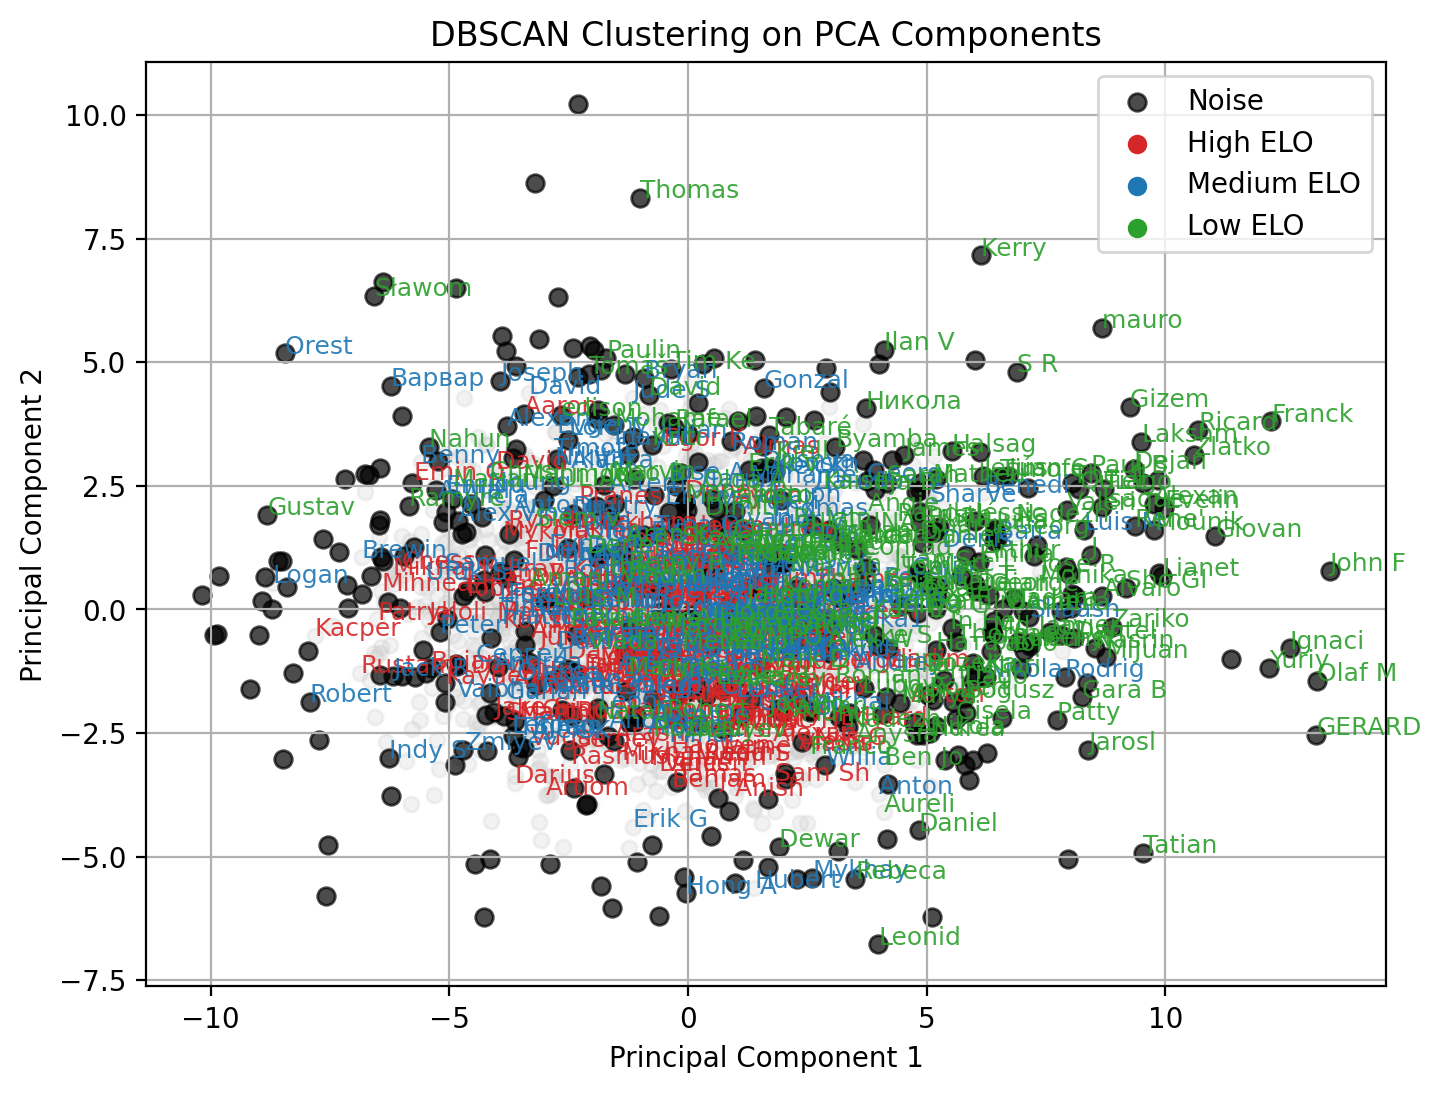

In [7]:
dbscan=DBSCAN(eps=3,min_samples=20)
#让噪声点变多：减小eps，增加min_samples
labels=dbscan.fit_predict(X_pca)
plt.figure(figsize=(8,6))
unique_labels=set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
df_sorted = df.sort_values(by='ELO')
lowest_players  = df_sorted.head(num_chosen).Name.values
highest_players = df_sorted.tail(num_chosen).Name.values
medium_players  = df_sorted.iloc[len(df)//2 : len(df)//2 + num_chosen].Name.values

df_sel = df.reset_index()  # 为了通过名字找到行号

for k in set(labels):
    mask = (labels == k)
    if k == -1:
        # Noise: 黑色
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c='k', s=40, alpha=0.7, label='Noise')
    else:
        # 非噪声 cluster：统一浅灰色
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c='#CCCCCC', s=30, alpha=0.25)

def plot_player_group(player_list, color, label):
    for name in player_list:
        if name not in df_sel.user.values:
            continue
        idx = df_sel[df_sel.user == name].index[0]
        plt.text(
            X_pca[idx, 0], X_pca[idx, 1], name[:6],
            color=color, fontsize=9, alpha=0.9
        )
    plt.scatter([], [], color=color, label=label)  # legend entry

plot_player_group(highest_players, 'C3', 'High ELO')
plot_player_group(medium_players, 'C0', 'Medium ELO')
plot_player_group(lowest_players, 'C2', 'Low ELO')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering on PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#获得这些噪声具体是谁，即noise_players里的人
noise_indices=np.where(labels==-1)[0]
#把噪音里的高水平玩家排除掉，不记为噪音
highest_players_names=df_sorted.tail(num_chosen).Name.values
highest_players_indices = df[df['Name'].isin(highest_players_names)].index.values
noise_indices = [idx for idx in noise_indices if idx not in highest_players_indices]
noise_players=df.iloc[noise_indices][['Name','ELO']]

for index, row in noise_players.iterrows():
    print(row['Name'], row['ELO'])
print(f'rows:{noise_players.shape[0]},columns:{noise_players.shape[1]}')

AFRUZA Khamdamova 2682.0
Abigail Zhou 2282.0
Adnan Sitnic 2392.0
Adrian Antonio Garcia Garcia 2531.0
Agustin Ambrogi 2545.0
Ahmed Kandil 2718.0
Aiaru Altynbek 2555.0
Akeem Brown 2422.0
Alan Morris-Suzuki 2694.0
Albert Fishman 2304.0
Aleksandar Topalov 2382.0
Aleksander Kumala 2553.0
Aleksandr Ivanov 2339.0
Aleksei Pridorozhni 2866.0
Alex Fishbein 2713.0
Alex Villa Tornero 2615.0
Alexander Alexikov 2279.0
Alexander Gelman 2763.0
Alexander Khlebovich 2906.0
Alexander Reprintsev 2641.0
Alexander Rustemov 2973.0
Alexander Spichkin 2413.0
Alexandr A Smirnov 2634.0
Alexandr Kostiukov 2321.0
Alexandra Prado 1791.0
Alexandra Samaganova 2376.0
Alexandre Qashashvili 2246.0
Alexandros Papasimakopoulos 2845.0
Alexandru-Bogdan Banzea 2596.0
Alexey Evdokimov 2671.0
Alexey Jarovinsky 2901.0
Alexey Streltsov 2737.0
Alfeu Junior Varela Bueno 2432.0
Ali Elier 2596.0
Ali Mortazavi 2540.0
Alisa Genrietta Yunker 2473.0
Aljoscha Feuerstack 2778.0
Alvaro Donatti 2205.0
Aman Hambleton 2960.0
Ameet Ghasi 2716.

In [9]:
#df_interpretate打算用来放排除掉噪音点和较差劲玩家的数据
df_interpretate=df.copy()
print(df.shape[0],df.shape[1])
df_interpretate=df_interpretate.drop(noise_indices)
print(df_interpretate.shape[0],df_interpretate.shape[1])
#输出结果正确，刚好差215行
#df_interpretate=df_interpretate[df_interpretate.TotalGames > 100][cols].fillna(0).reset_index(drop=True)
#print(df_interpretate.shape[0],df_interpretate.shape[1])

2695 73
2240 73


In [10]:
print(df['ELO'].describe())
print((df['ELO']>2800).value_counts())  #这个可以调的，选的顶级棋手，免得其实不咋厉害的人反而子维度分很高
df_interpretate=df_interpretate[df_interpretate['ELO']>2800].copy()

count    2695.000000
mean     2607.291280
std       253.227287
min      1533.000000
25%      2452.000000
50%      2604.000000
75%      2777.000000
max      3319.000000
Name: ELO, dtype: float64
ELO
False    2084
True      611
Name: count, dtype: int64


对这些顶级棋手聚类，尝试解释风格

In [11]:
df_interpretate_flit=df_interpretate[df_interpretate.TotalGames>100][cols].fillna(0).reset_index(drop=True)
interpretate_X_pca = pca_pipeline.fit_transform(df_interpretate_flit.values)

In [12]:
df_interpretate_pca = pd.DataFrame({
    "PC1": interpretate_X_pca[:, 0],
    "PC2": interpretate_X_pca[:, 1],
    "Name": df_interpretate.user.values
})

top_highest_players = df_sorted.tail(30).Name.values
#选top玩家
df_interpretate_pca["is_top"] = df_interpretate_pca["Name"].isin(top_highest_players)
#只有top玩家显示文字，其他玩家为空
df_interpretate_pca["text"] = df_interpretate_pca["Name"].where(df_interpretate_pca["is_top"], "")

fig = px.scatter(
    df_interpretate_pca,
    x="PC1",
    y="PC2",
    color="is_top",
    text="text",          #只显示 top 的名字
    hover_name="Name",    #其他一般的玩家只有悬停的时候才显示名字
    opacity=0.6
)
fig.update_traces(textposition="top center")
fig.update_layout(
    width=1200,
    height=900,
    showlegend=False,
    title="Interactive PCA Scatter Plot (Plotly)"
)

fig.update_xaxes(zeroline=True, zerolinewidth=1,zerolinecolor='red')
fig.update_yaxes(zeroline=True, zerolinewidth=1,zerolinecolor='red')

fig.show()

# 筛选 top 玩家
top_coords = df_interpretate_pca[df_interpretate_pca["is_top"]][["Name", "PC1", "PC2"]]

# 打印出来
print(top_coords)

                          Name       PC1       PC2
24              Aleksei Sarana -0.206165 -0.814069
44            Alireza Firouzja  3.122513  0.278718
59               Andy Woodward -0.197100  2.498734
71              Arjun Erigaisi  1.858883  1.342275
102         Bogdan Daniel Deac  0.990569 -2.647388
138              Denis Lazavik  1.136290 -3.626058
149           Dmitry Andreikin  3.127765 -1.664289
155                 Ediz Gürel -1.156429  1.656987
174            Fabiano Caruana  0.532517 -1.337427
176               Faustino Oro  1.142411  1.222905
211               Hans Niemann  1.246391  0.221647
215            Hikaru Nakamura  1.586566 -0.620532
218         Ian Nepomniachtchi  0.351189  1.118203
234           Ivan Zemlyanskii  3.887812 -0.054041
248         Jan-Krzysztof Duda  1.166583 -0.281384
250          Javokhir Sindarov  2.816425 -2.009961
309             Magnus Carlsen  1.319602 -1.505788
310           Mahammad Muradli  1.098085 -3.201683
338     Maxime Vachier-Lagrave 

## ♟️ PCA 降维结果解读：棋风分类体系

基于 Titled Tuesday 过去五年数据的 PCA 分析，我们成功提取了两个核心维度来定义棋手的风格。

### ↔️ X轴 (PC1)：局面控制 vs. 战术乱战 (Positional Control vs. Tactical Chaos)
**这一维度衡量的是棋局的“秩序感”与“精确度”。**

* **右侧 (Positive, > 0): 局面统治型 (Dominant / Positional)**
    * **风格描述：** 依靠对中心的绝对控制、协调的子力位置和完整的兵型结构获胜。招法客观精确，接近引擎首选，讲究“秩序”与“压制”。
    * **关键特征：** `CenterControlScore` (中心控制), `PieceActivityScore` (子力活跃), `pawn_1Life/2Life` (结构完整)。
    * **代表棋手：** **Tuan Minh Le, Wesley So, Alireza Firouzja**（表现出极高的统治力和机器般的精确度）。

* **左侧 (Negative, < 0): 战术搏杀型 (Scrappy / Tactical)**
    * **风格描述：** 依靠复杂的战术纠缠、制造混乱（将军/逃跑）和机会主义陷阱获胜。局面往往支离破碎，充满了不确定性和泥潭般的互搏。
    * **关键特征：** `CheckRatio` (将军频率), `KingEscapeSquaresScore` (老王逃跑), `ForceRatio` (剧烈兑子)。
    * **代表棋手：** **Oleksandr Bortnyk, Pranesh M**（擅长在混乱局面中生存和反杀）。

---

### ↕️ Y轴 (PC2)：激进进攻 vs. 稳健防守 (Aggressive vs. Solid)
**这一维度衡量的是棋手的“侵略意图”与“风险偏好”。**

* **上方 (Positive, > 0): 激进突破型 (Aggressive / Dynamic)**
    * **风格描述：** 极具攻击欲望，倾向于冒风险将兵冲至深处（第6/7线）或将车杀入底线，寻求升变或杀王。
    * **关键特征：** `pawn_6LifeRatio`, `pawn_7LifeRatio` (兵冲到底), `rook_2LifeRatio` (车沉底侵略)。
    * **代表棋手：** **Pranesh M, Ian Nepomniachtchi**（锋利的攻击手）。

* **下方 (Negative, < 0): 稳健坚实型 (Solid / Fortress)**
    * **风格描述：** 防守反击风格，兵主要停留在第3/4线构筑坚固防线，注重兵链保护，极大降低输棋风险，像堡垒一样难以攻破。
    * **关键特征：** `pawn_3LifeRatio`, `pawn_4LifeRatio` (兵在低位), `PawnProtectScore` (兵链互保), `rook_1LifeRatio` (底线防守)。
    * **代表棋手：** **Denis Lazavik** (极致的稳健), **Magnus Carlsen** (极强的磨控能力)。

---

### 🧩 四象限风格画像
1.  **右上 (High Control + Aggressive): 全能杀手 (The Lethal Dominators)** —— 既有统治力又极其锋利 (e.g., Firouzja)。
2.  **右下 (High Control + Solid): 叹息之墙 (The Iron Grinders)** —— 统治力强且滴水不漏 (e.g., Carlsen, Lazavik)。
3.  **左上 (High Chaos + Aggressive): 狂战士 (The Berserkers)** —— 局面混乱且进攻凶猛 (e.g., Pranesh M)。
4.  **左下 (High Chaos + Solid): 顽强防守者 (The Tricky Defenders)** —— 局面被动但极难彻底击溃 (e.g., Bortnyk)。

## ♟️ PCA Interpretation: Chess Style Taxonomy

Based on PCA analysis of Titled Tuesday data from the last five years, we define player styles using two principal components.

### ↔️ X-Axis (PC1): Positional Control vs. Tactical Chaos
**Measures the level of "Order" and "Precision" in the game.**

* **Right Side (Positive, > 0): Positional / Dominant**
    * **Description:** Wins through absolute center control, coordinated piece activity, and sound pawn structures. Moves are objective, precise, and engine-correlated.
    * **Key Features:** `CenterControlScore`, `PieceActivityScore`, `pawn_1Life/2Life` (Structure Integrity).
    * **Notable Players:** **Tuan Minh Le, Wesley So, Alireza Firouzja** (Machine-like precision and control).

* **Left Side (Negative, < 0): Tactical / Scrappy**
    * **Description:** Wins through complications, tactical scrambles, and creating chaos (checks/king runs). The position is often messy, relying on swindles or sharp calculations.
    * **Key Features:** `CheckRatio`, `KingEscapeSquaresScore`, `ForceRatio` (High Exchange Rate).
    * **Notable Players:** **Oleksandr Bortnyk, Pranesh M** (Thriving in chaotic, messy positions).

---

### ↕️ Y-Axis (PC2): Aggressive vs. Solid
**Measures "Aggression Intent" and "Risk Appetite".**

* **Top (Positive, > 0): Aggressive / Dynamic**
    * **Description:** High willingness to take risks, pushing pawns deep (6th/7th ranks) and invading with rooks to create mating threats or promotion chances.
    * **Key Features:** `pawn_6LifeRatio`, `pawn_7LifeRatio` (Deep Advancement), `rook_2LifeRatio` (Invasion).
    * **Notable Players:** **Pranesh M, Ian Nepomniachtchi** (Sharp, attacking style).

* **Bottom (Negative, < 0): Solid / Fortress**
    * **Description:** Risk-averse style. Pawns stay on 3rd/4th ranks to build unbreakable chains. Focuses on prophylaxis and restricting the opponent.
    * **Key Features:** `pawn_3LifeRatio`, `pawn_4LifeRatio` (Conservative structure), `PawnProtectScore`, `rook_1LifeRatio` (Defense).
    * **Notable Players:** **Denis Lazavik** (The "Fortress"), **Magnus Carlsen** (Positional grinding).

---

### 🧩 Quadrant Personas
1.  **Top-Right (Control + Aggressive): The Lethal Dominators** —— Surgical precision with killer instinct (e.g., Firouzja).
2.  **Bottom-Right (Control + Solid): The Iron Grinders** —— Unbreakable positional squeeze (e.g., Carlsen, Lazavik).
3.  **Top-Left (Chaos + Aggressive): The Berserkers** —— Messy positions with heavy attacks (e.g., Pranesh M).
4.  **Bottom-Left (Chaos + Solid): The Tricky Defenders** —— Scrappy defense in passive positions (e.g., Bortnyk).

In [13]:
import plotly.express as px

# 1. 提取 PCA 模型
# 如果报错，说明你的 pipeline 最后一步不叫 'pca'，请改为 pca_model = pca_pipeline[-1]
pca_model = pca_pipeline.named_steps['pca'] 

# 获取实际计算出的 PC 数量 (比如你之前设了2，这里就是2)
n_components = pca_model.n_components_
print(f"当前模型包含 {n_components} 个主成分。")

# 2. 提取特征权重 (Loadings)
loadings_df = pd.DataFrame(
    pca_model.components_.T, 
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=cols
)

# ----------------------------------------------------------
# 可视化 A：特征权重热力图
# ----------------------------------------------------------
fig_heatmap = px.imshow(
    loadings_df, 
    labels=dict(x="Principal Components", y="Feature Name", color="Weight"),
    x=loadings_df.columns,
    y=loadings_df.index,
    color_continuous_scale='RdBu_r', 
    zmin=-0.5, zmax=0.5,             
    aspect="auto",
    height=1200,                    
    title=f"Feature Contribution Heatmap ({n_components} PCs)"
)
fig_heatmap.show()

# ----------------------------------------------------------
# 文字输出 B：详细排序 (自动适配 PC 数量)
# ----------------------------------------------------------
print("\n" + "="*50)
print(">>> PCA 主成分特征详细排序 <<<")
print("="*50)

# 循环次数改为 n_components，有多少显示多少，不再强行显示 5 个
for i in range(n_components): 
    pc_name = f"PC{i+1}"
    
    # 排序
    sorted_features = loadings_df[pc_name].sort_values(ascending=False)
    
    print(f"\n【{pc_name} 解析】")
    print(f"  ⬆️ 正向最强特征 (值越大 {pc_name} 越大):")
    print(f"     {', '.join(sorted_features.head(5).index)}")
    
    print(f"  ⬇️ 负向最强特征 (值越小 {pc_name} 越小):")
    print(f"     {', '.join(sorted_features.tail(5).index)}")

当前模型包含 10 个主成分。



>>> PCA 主成分特征详细排序 <<<

【PC1 解析】
  ⬆️ 正向最强特征 (值越大 PC1 越大):
     CenterControlScore, pawn_1LifeRatio, PieceActivityScore, KingDiagonalExposureScore, pawn_2LifeRatio
  ⬇️ 负向最强特征 (值越小 PC1 越小):
     queen_promo_2LifeRatio, ForceRatio, CheckRatio, KingEscapeSquaresScore, AveragePawnAdvanceDepth

【PC2 解析】
  ⬆️ 正向最强特征 (值越大 PC2 越大):
     pawn_6LifeRatio, rook_2LifeRatio, ForceRatio, PieceActivityScore, pawn_7LifeRatio
  ⬇️ 负向最强特征 (值越小 PC2 越小):
     AveragePawnAdvanceDepth, pawn_3LifeRatio, rook_1LifeRatio, PawnProtectScore, pawn_4LifeRatio

【PC3 解析】
  ⬆️ 正向最强特征 (值越大 PC3 越大):
     KingTropismScore, CaptureRatio, CheckRatio, KingSafetyScore, KingPawnShieldScore
  ⬇️ 负向最强特征 (值越小 PC3 越小):
     pawn_4LifeRatio, queen_1LifeRatio, bishop_1LifeRatio, pawn_5LifeRatio, PawnProtectScore

【PC4 解析】
  ⬆️ 正向最强特征 (值越大 PC4 越大):
     queen_promo_5LifeRatio, queen_promo_4LifeRatio, queen_promo_6LifeRatio, queen_promo_3LifeRatio, queen_promo_2LifeRatio
  ⬇️ 负向最强特征 (值越小 PC4 越小):
     PieceActivityScore, queen_1Lif

# 1.Dynamic/Aggressive binary classification 
Negetive samples: players at Y-axis's top   
Positive samples: players at Y-axis's bottom    

In [14]:
#get the name lists of positive players abnd negetive players
#use 10% of people to make the classifer to learn
percent_10 = int(len(df_interpretate_pca) *0.1)
print(percent_10)
#positive samples
# 按 y 轴从高到低排序
Dynamic_positive_players = df_interpretate_pca.sort_values("PC2", ascending=False).head(percent_10)
# 只要名字
Dynamic_positive_names = Dynamic_positive_players["Name"].tolist()
print(Dynamic_positive_names)

#negetive samples
Dynamic_negetive_players=df_interpretate_pca.sort_values('PC2',ascending=True).head(percent_10)
Dynamic_negetive_names=Dynamic_negetive_players['Name'].tolist()
print(Dynamic_negetive_names)

55
['Sebastian Mihajlov', 'Aaron Jacobson', 'Deniel Safarov', 'Egor Koshulyan', 'Almas Rakhmatullaev', 'Dachey Lin', 'Sahaj Grover', 'Zachary Tanenbaum', 'Johan-Sebastian Christiansen', 'Nitin Senthilvel', 'Klementy Sychev', 'David Gavrilescu', 'Silvius Tiberius', 'Satria Duta Cahaya', 'Denes Boros', 'Daniel Chan', 'Leo Valle Luis', 'Levy Rozman', 'Krzysztof Jakubowski', 'Lucas Do Valle Cardoso', 'Dominik Horvath', 'Aydin Suleymanli', 'Shahruh Turayev', 'Ilamparthi A R', 'Alexei Shirov', 'Francisco Javier Muñoz', 'Gevorg Harutjunyan', 'Vadym Petrovskyi', 'Maxim Lugovskoy', 'Owen McCoy', 'Kirill Alekseenko', 'Alexander Velikanov', 'Maksim Ivannikov', 'Adar TARHAN', 'Pranesh M', 'Matvey Galchenko', 'Seyed Abolfazl Moosavifar', 'Floryan Eugene', 'Mikhail Antipov', 'Nikolozi Kacharava', 'Maciej Klekowski', 'Abdulla Gadimbayli', 'Emin Ohanyan', 'Bobur Sattarov', 'Andrew Tang', 'Sathvik Adiga', 'Apoorv Kamble', 'Шубин Кирилл', 'Luka Paichadze', 'Alex Fier', 'Sravan Renjith', 'Miłosz Szpar', 

In [15]:
#Dynamic_1_players记录的是对应的选手信息表
Dynamic_1_players= df[df["user"].isin(Dynamic_positive_names)]
Dynamic_0_players=df[df['user'].isin(Dynamic_negetive_names)]
Dynamic_1_players

,Unnamed: 0,user,CenterControlScore,PieceActivityScore,KingSafetyScore,CastlingScore,KingTropismScore,KingDefendersScore,KingPawnShieldScore,KingZoneControlScore,...,knight_promo_1LifeRatio,knight_promo_2LifeRatio,knight_promo_3LifeRatio,knight_promo_4LifeRatio,knight_promo_5LifeRatio,knight_promo_6LifeRatio,knight_promo_7LifeRatio,knight_promo_8LifeRatio,Name,ELO
14,14,Aaron Jacobson,19.088649,181.048842,-63.112886,-14.650555,-12.029564,3.997822,-6.119282,-35.911994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Jacobson,3062.0
18,18,Abdulla Gadimbayli,19.451422,180.624069,-57.768043,-15.399012,-11.036538,3.989739,-5.001580,-32.171562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abdulla Gadimbayli,2831.0
28,28,Adar TARHAN,19.536407,183.015460,-60.333668,-14.166879,-11.820410,3.995638,-5.656488,-34.537580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adar TARHAN,2828.0
110,110,Alex Fier,19.197861,183.845399,-63.915752,-14.761522,-12.319829,3.985213,-5.929654,-36.035869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Fier,2822.0
141,141,Alexander Velikanov,20.034065,190.243501,-60.934165,-15.193604,-11.911659,3.997793,-5.301900,-33.875497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alexander Velikanov,2806.0
163,163,Alexei Shirov,20.099103,185.174819,-59.455114,-14.247921,-11.661001,3.997970,-6.476717,-33.410622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alexei Shirov,2955.0
197,197,Almas Rakhmatullaev,20.490780,195.955970,-62.341403,-14.720659,-11.856325,3.996550,-6.339169,-34.897111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Almas Rakhmatullaev,3047.0
253,253,Andrew Tang,20.562054,194.688485,-62.654475,-14.071521,-12.150962,3.997774,-7.385988,-34.899378,...,0.039538,0.013158,NaN,NaN,NaN,NaN,NaN,NaN,Andrew Tang,3106.0
272,272,Andy Woodward,20.274265,189.749137,-62.271627,-14.766429,-12.128766,3.998210,-6.160275,-34.608688,...,0.095984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andy Woodward,3171.0
306,306,Apoorv Kamble,19.796692,184.337221,-62.302211,-15.043494,-12.207757,3.993168,-5.232602,-34.922696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apoorv Kamble,2856.0


only 55 positive samples and 55 negetive samples,   
try to get more samples from these players' raw game table: kingsafety&lifespan

In [16]:
#1. Filter out short games : moves<20  
#2. Mini-batch : Aggregation 10 games' average  
import sqlite3
db_file=r"C:\sqlite3\chess.db"
conn=sqlite3.connect(db_file)
table1='lifespan'
playercolumn1='player'
Dynamic_1_holders = ",".join(["?"] * len(Dynamic_positive_names))
query = f"""
SELECT *
FROM {table1}
WHERE {playercolumn1} IN ({Dynamic_1_holders})
"""
Dynamic_1_lifespan_all = pd.read_sql(query, conn, params=Dynamic_positive_names)
Dynamic_1_lifespan_all

,uid,player,king_1Span,king_1LifeRatio,queen_1Span,queen_1LifeRatio,rook_1Span,rook_1LifeRatio,rook_2Span,rook_2LifeRatio,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,20,Pranesh M,"(0, 49)",1.0,"(0, 49)",1.0,"(0, 25)",0.5102040816326531,"(0, 49)",1.0,...,None,None,None,None,None,None,None,None,None,None
1,32,Klementy Sychev,"(0, 56)",1.0,"(0, 56)",1.0,"(0, 56)",1.0,"(0, 56)",1.0,...,None,None,None,None,None,None,None,None,None,None
2,49,Alex Fier,"(0, 99)",1.0,"(0, 54)",0.5454545454545454,"(0, 99)",1.0,"(0, 99)",1.0,...,None,None,None,None,None,None,None,None,None,None
3,56,Johan-Sebastian Christiansen,"(0, 87)",1.0,"(0, 22)",0.2528735632183908,"(0, 87)",1.0,"(0, 74)",0.8505747126436781,...,None,None,None,None,None,None,None,None,None,None
4,68,Levy Rozman,"(0, 44)",1.0,"(0, 44)",1.0,"(0, 44)",1.0,"(0, 44)",1.0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33938,1017498,Silvius Tiberius,"(0, 148)",1.0,"(0, 111)",0.75,"(0, 148)",1.0,"(0, 63)",0.4256756756756756,...,None,None,None,None,None,None,None,None,None,None
33939,1017518,Gevorg Harutjunyan,"(0, 152)",1.0,"(0, 35)",0.2302631578947368,"(0, 32)",0.2105263157894736,"(0, 67)",0.4407894736842105,...,None,None,None,None,None,None,None,None,None,None
33940,1017526,Gevorg Harutjunyan,"(0, 24)",1.0,"(0, 24)",1.0,"(0, 24)",1.0,"(0, 24)",1.0,...,None,None,None,None,None,None,None,None,None,None
33941,1017542,Silvius Tiberius,"(0, 33)",1.0,"(0, 33)",1.0,"(0, 33)",1.0,"(0, 33)",1.0,...,None,None,None,None,None,None,None,None,None,None


In [17]:
Dynamic_0_holders = ",".join(["?"] * len(Dynamic_negetive_names))
query = f"""
SELECT *
FROM {table1}
WHERE {playercolumn1} IN ({Dynamic_0_holders})
"""
Dynamic_0_lifespan_all = pd.read_sql(query, conn, params=Dynamic_negetive_names)
Dynamic_0_lifespan_all

,uid,player,king_1Span,king_1LifeRatio,queen_1Span,queen_1LifeRatio,rook_1Span,rook_1LifeRatio,rook_2Span,rook_2LifeRatio,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,5,Alexander Donchenko,"(0, 31)",1.0,"(0, 31)",1.0,"(0, 31)",1.0,"(0, 31)",1.0,...,None,None,None,None,None,None,None,None,None,None
1,36,Shant Sargsyan,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 31)",0.5740740740740741,...,None,None,None,None,None,None,None,None,None,None
2,43,Benjamin Bok,"(0, 60)",1.0,"(0, 33)",0.55,"(0, 60)",1.0,"(0, 51)",0.85,...,None,None,None,None,None,None,None,None,None,None
3,66,Mikhail Demidov,"(0, 50)",1.0,"(0, 50)",1.0,"(0, 50)",1.0,"(0, 50)",1.0,...,None,None,None,None,None,None,None,None,None,None
4,70,Bogdan Daniel Deac,"(0, 47)",1.0,"(0, 47)",1.0,"(0, 47)",1.0,"(0, 36)",0.7659574468085106,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48754,1017542,Vignesh N.R,"(0, 33)",1.0,"(0, 33)",1.0,"(0, 33)",1.0,"(0, 33)",1.0,...,None,None,None,None,None,None,None,None,None,None
48755,1017595,Rasmus Svane,"(0, 82)",1.0,"(0, 82)",1.0,"(0, 82)",1.0,"(0, 69)",0.8414634146341463,...,None,None,None,None,None,None,None,None,None,None
48756,1017609,Aradhya Garg,"(0, 112)",1.0,"(0, 112)",1.0,"(0, 28)",0.25,"(0, 47)",0.4196428571428571,...,None,None,None,None,None,None,None,None,None,None
48757,1017621,Denis Lazavik,"(0, 69)",1.0,"(0, 69)",1.0,"(0, 34)",0.4927536231884058,"(0, 53)",0.7681159420289855,...,None,None,None,None,None,None,None,None,None,None


In [18]:
table2='kingsafety'
ks_cols=pd.read_sql("PRAGMA table_info(kingsafety);",conn)['name'].tolist()
ks_white_cols=['uid']+[c for c in ks_cols if c.startswith('White_')]
ks_black_cols=['uid']+[c for c in ks_cols if c.startswith('Black_')]
#positive
query_white = f"""
SELECT {", ".join(ks_white_cols)}
FROM kingsafety
WHERE White_player_id IN ({Dynamic_1_holders})
"""
Dynamic_ks_white_1=pd.read_sql(query_white,conn,params=Dynamic_positive_names)
Dynamic_ks_white_1['color'] = 'White'
#重命名白方列
white_rename_map={col:col.replace('White_','') for col in ks_white_cols} 
Dynamic_ks_white_1=Dynamic_ks_white_1.rename(columns=white_rename_map)
query_black=f"""
SELECT {", ".join(ks_black_cols)}
FROM kingsafety
WHERE Black_player_id IN ({Dynamic_1_holders})
"""
Dynamic_ks_black_1=pd.read_sql(query_black,conn,params=Dynamic_positive_names)
Dynamic_ks_black_1['color'] = 'Black'
#重命名黑方列
black_rename_map={col:col.replace('Black_','') for col in ks_black_cols}
Dynamic_ks_black_1=Dynamic_ks_black_1.rename(columns=black_rename_map)

#df_merged = A.merge(B, left_on="a", right_on="b", how="inner")
Dynamic_1_ks_all=pd.concat([Dynamic_ks_white_1,Dynamic_ks_black_1],axis=0,ignore_index=True)
Dynamic_1_ks_all 

,uid,CenterControlScoresList,PieceActivityScoresList,KingSafetyScoresList,CastlingScoresList,KingTropismScoresList,KingDefendersScoresList,KingPawnShieldScoresList,KingZoneControlScoresList,KingDiagonalExposureScoresList,...,PieceActivityScoreMean,KingSafetyScoreMean,CastlingScoreMean,KingTropismScoreMean,KingDefendersScoreMean,KingPawnShieldScoreMean,KingZoneControlScoreMean,KingDiagonalExposureScoreMean,KingEscapeSquaresScoreMean,color
0,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,222.36,-21.81615419501134,-14.4,-9.69615419501134,4.0,6.4,-4.2,-9.72,5.8,White
1,49,"[13, 18.0, 22.0, 20.0, 19, 20.0, 22.0, 22.0, 2...","[148.0, 150.0, 180.0, 196.0, 214.0, 223.0, 226...","[-5.5487528344671215, -5.895975056689343, -19....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -20...","[-8.548752834467122, -8.895975056689343, -9.01...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, -15, -15, -15, -15, -15, -15, -15, -15,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -15...","[-6, -6, -9, -9, -9, -9, -9, -9, -6, -6, -6, -...",...,153.92,-57.33885827664399,-14.4,-11.018858276643993,4.0,-5.1,-34.8,-9.72,13.7,White
2,56,"[13, 17.0, 20.0, 23.0, 23.0, 19.0, 14.0, 17.0,...","[148.0, 178.0, 198.0, 224.0, 222.0, 222.0, 198...","[-5.5487528344671215, -18.670975056689343, -16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -20, -20, -2...","[-8.548752834467122, -8.670975056689343, -9.01...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, -15, -15, -15, -15, -15, -15, -15, -15, -1...","[0, 0, 0, 0, 0, 0, 0, -45.0, -45.0, -45.0, 0, ...","[-6, -9, -6, -6, -9, -9, -9, -9, -9, -9, -9, -...",...,126.6818181818182,-52.658391311069884,-15.0,-10.453845856524428,4.0,-7.840909090909091,-28.295454545454547,-11.659090909090908,16.59090909090909,White
3,173,"[10, 11, 16.0, 19.0, 18.0, 18.0, 21.0, 21.0, 2...","[109.0, 109.0, 129.0, 150.0, 165.0, 183.0, 197...","[-8.548752834467122, -8.270975056689343, -8.39...","[0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20, -2...","[-8.548752834467122, -8.270975056689343, -8.39...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, -15, -15, -15, 0, 0, 0, 10, 10, 10, ...","[0, 0, 0, -15.0, -100, -100, -30.0, -30.0, -30...","[-9, -9, -9, -9, -9, -9, -12, -12, -12, -12, -...",...,202.1290322580645,-107.27414417379856,-16.129032258064516,-16.661240947992102,4.0,-8.548387096774194,-63.2258064516129,-11.225806451612904,4.516129032258065,White
4,232,"[13, 18.0, 22.0, 20.0, 23.0, 29.0, 30.0, 30.0,...","[148.0, 150.0, 180.0, 196.0, 216.0, 242.0, 259...","[-5.5487528344671215, -5.895975056689343, -19....","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -9.01...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, -15, -15, -15, -15, -15, 15, 15, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, -15.0, -15.0, -15....","[-6, -6, -9, -9, -6, -6, -6, -9, -9, -9, -9, -...",...,133.14545454545456,-96.03737992166565,-17.454545454545453,-25.41919810348382,4.0,-3.727272727272727,-50.36363636363637,-12.981818181818182,9.909090909090908,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33938,1017198,"[10, 10, 11, 12.0, 25.0, 18.0, 21.0, 24.0, 18....","[127.0, 130.0, 130.0, 148.0, 168.0, 189.0, 234...","[4.104024943310657, 3.5162698412698408, 3.7940...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -20, -20, -20, ...","[-8.895975056689343, -9.48373015873016, -9.205...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, -100, -100, 0, 0, -30.0, 0, -100, -6...","[-6, -6, -6,

In [19]:
table2='kingsafety'
ks_cols=pd.read_sql("PRAGMA table_info(kingsafety);",conn)['name'].tolist()
ks_white_cols=['uid']+[c for c in ks_cols if c.startswith('White_')]
ks_black_cols=['uid']+[c for c in ks_cols if c.startswith('Black_')]
#negetive
query_white = f"""
SELECT {", ".join(ks_white_cols)}
FROM kingsafety
WHERE White_player_id IN ({Dynamic_0_holders})
"""
Dynamic_ks_white_0=pd.read_sql(query_white,conn,params=Dynamic_negetive_names)
Dynamic_ks_white_0['color'] = 'White'
#重命名白方列
white_rename_map={col:col.replace('White_','') for col in ks_white_cols} 
Dynamic_ks_white_0=Dynamic_ks_white_0.rename(columns=white_rename_map)
query_black=f"""
SELECT {", ".join(ks_black_cols)}
FROM kingsafety
WHERE Black_player_id IN ({Dynamic_0_holders})
"""
Dynamic_ks_black_0=pd.read_sql(query_black,conn,params=Dynamic_negetive_names)
Dynamic_ks_black_0['color'] = 'Black'
#重命名黑方列
black_rename_map={col:col.replace('Black_','') for col in ks_black_cols}
Dynamic_ks_black_0=Dynamic_ks_black_0.rename(columns=black_rename_map)

#df_merged = A.merge(B, left_on="a", right_on="b", how="inner")
Dynamic_0_ks_all=pd.concat([Dynamic_ks_white_0,Dynamic_ks_black_0],axis=0,ignore_index=True)
Dynamic_0_ks_all

,uid,CenterControlScoresList,PieceActivityScoresList,KingSafetyScoresList,CastlingScoresList,KingTropismScoresList,KingDefendersScoresList,KingPawnShieldScoresList,KingZoneControlScoresList,KingDiagonalExposureScoresList,...,PieceActivityScoreMean,KingSafetyScoreMean,CastlingScoreMean,KingTropismScoreMean,KingDefendersScoreMean,KingPawnShieldScoreMean,KingZoneControlScoreMean,KingDiagonalExposureScoreMean,KingEscapeSquaresScoreMean,color
0,5,"[14.0, 14.0, 14.0, 12.0, 12.0, 14.0, 15.0, 16....","[139.0, 157.0, 160.0, 144.0, 149.0, 203.0, 221...","[-8.548752834467122, -9.136507936507936, -9.25...","[0, 0, 0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20...","[-8.548752834467122, -9.136507936507936, -9.25...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, -15.0, -15.0, 0, -5.0, -5.0, -50.0, ...","[-9, -9, -9, -6, -6, -6, -6, -6, -6, -9, -9, -...",...,204.0625,-39.241510770975054,-8.75,-11.616510770975056,4.0,0.0,-21.5625,-7.875,6.5625,White
1,70,"[14.0, 14.0, 19.0, 21.0, 21.0, 22.0, 24.0, 25....","[139.0, 157.0, 177.0, 183.0, 177.0, 189.0, 199...","[-8.548752834467122, -8.895975056689343, -9.01...","[0, 0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -...","[-8.548752834467122, -8.895975056689343, -9.01...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, -15, -15, -15, -15, -15, 15, 15, 15,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-9, -9, -9, -9, -9, -9, -6, -6, -9, -9, -9, -...",...,221.875,-17.919812925170067,-13.333333333333334,-9.3781462585034,4.0,5.0,-4.375,-9.0,9.166666666666666,White
2,116,"[10, 10, 14, 16.0, 16.0, 17.0, 17.0, 18.0, 21....","[127.0, 130.0, 145.0, 158.0, 167.0, 176.0, 176...","[4.4512471655328785, 3.863492063492064, 8.7412...","[0, 0, 0, 0, -20, -20, -20, -20, -20, -20, -20...","[-8.548752834467122, -9.136507936507936, -9.25...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, -15.0, -15.0, -60.0, ...","[-6, -6, -6, -6, -9, -9, -9, -9, -9, -9, -9, -...",...,210.24242424242425,-33.38641173641174,-17.575757575757574,-9.356108706108705,4.0,1.818181818181818,-10.454545454545457,-8.636363636363637,6.818181818181818,White
3,331,"[10, 15.0, 20.0, 18.0, 21.0, 23.0, 23.0, 23.0,...","[127.0, 147.0, 167.0, 170.0, 178.0, 178.0, 187...","[4.4512471655328785, 4.104024943310657, 3.5162...","[0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20, -2...","[-8.548752834467122, -8.895975056689343, -9.48...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, -15.0, -15.0, -30.0, -30.0, -3...","[-6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -9, -...",...,244.17021276595744,-66.30348458532349,-17.4468085106383,-11.346037776812857,4.0,-6.595744680851064,-35.212765957446805,-8.74468085106383,9.04255319148936,White
4,350,"[14.0, 17.0, 17.0, 20.0, 20.0, 23.0, 25.0, 23....","[139.0, 178.0, 178.0, 178.0, 190.0, 210.0, 221...","[-8.548752834467122, -18.670975056689343, -18....","[0, 0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -...","[-8.548752834467122, -8.670975056689343, -8.39...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, -15, -15, -15, -15, -15, -15, -15, 15, 15,...","[0, 0, 0, 0, 0, 0, 0, 0, -45.0, -45.0, -60.0, ...","[-9, -9, -9, -9, -9, -6, -6, -6, -9, -9, -12, ...",...,182.03225806451613,-54.7090227488845,-14.838709677419354,-9.67676468436837,4.0,-18.387096774193548,-22.258064516129032,-11.612903225806452,18.06451612903226,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48754,1017475,"[10.0, 14.0, 17.0, 13.0, 15.0, 16.0, 17.0, 19....","[127.0, 157.0, 169.0, 166.0, 187.0, 199.0, 188...","[4.104024943310657, -6.483730158730159, -7.071...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -20, -20,...","[-8.895975056689343, -9.48373015873016, -10.07...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 0, 0, 0, -15, -15, -15, -15, -15, -15, -1...","[0, 0, 0, 0, -90.0, 

In [20]:
#把chaos_1/0_ks_all里的list都丢掉
Dynamic_0_ks_all=Dynamic_0_ks_all.drop(columns=[col for col in Dynamic_0_ks_all.columns if col.endswith('List')])
Dynamic_1_ks_all=Dynamic_1_ks_all.drop(columns=[col for col in Dynamic_1_ks_all.columns if col.endswith('List')])

In [21]:
Dynamic_0_ks_all = Dynamic_0_ks_all.sort_values("uid").reset_index(drop=True)
Dynamic_0_lifespan_all = Dynamic_0_lifespan_all.sort_values("uid").reset_index(drop=True)
mismatch = Dynamic_0_ks_all['uid'] != Dynamic_0_lifespan_all['uid']
if mismatch.any():
    bad_rows = Dynamic_0_ks_all.loc[mismatch, 'uid']
    print("不一致的 uid 行如下：")
    print(bad_rows)
    raise ValueError("排序后 uid 仍不一致，可能表结构有问题")
else:
    print("排序后 uid 完全一致，可以安全横向合并")
Dynamic_0_lifespan_all = Dynamic_0_lifespan_all.drop(columns=['uid'])
Dynamic_0_all = pd.concat([Dynamic_0_ks_all, Dynamic_0_lifespan_all], axis=1)
Dynamic_0_all

排序后 uid 完全一致，可以安全横向合并


,uid,castled,LostCastlingRights,lost_castling_rights,game_id,player_id,CenterControlScoreMean,PieceActivityScoreMean,KingSafetyScoreMean,CastlingScoreMean,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,100,False,False,True,100,Denis Lazavik,20.29032258064516,202.25806451612905,-37.34624387389364,-14.193548387096774,...,None,None,None,None,None,None,None,None,None,None
1,1000007,False,False,True,1000007.0,Rasmus Svane,25.21875,236.28125,-69.65620571145125,-16.875,...,None,None,None,None,None,None,None,None,None,None
2,1000015,False,False,True,1000015.0,Alexander Zubov,19.23333333333333,202.16666666666663,-45.027297808012094,-12.0,...,None,None,None,None,None,None,None,None,None,None
3,1000026,False,False,True,1000026.0,Artem Timofeev,22.4390243902439,221.7317073170732,-68.26889414302306,-17.073170731707318,...,None,None,None,None,None,None,None,None,None,None
4,1000071,False,False,True,1000071.0,Vincent Keymer,15.465116279069768,121.27906976744184,-82.65398275589305,-13.953488372093023,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48754,999960,False,False,True,999960.0,Gerson Príncipe,21.28,222.08,-22.351179138322,-12.8,...,None,None,None,None,None,None,None,None,None,None
48755,999968,False,False,True,999968.0,Mahammad Muradli,23.21875,214.0,-63.46809807256236,-15.625,...,None,None,None,None,None,None,None,None,None,None
48756,999970,False,False,True,999970.0,Varuzhan Akobian,25.217391304347824,244.2826086956522,-42.35961130829144,-16.52173913043478,...,None,None,None,None,None,None,None,None,None,None
48757,999977,False,False,True,999977.0,Bogdan Daniel Deac,23.24137931034483,199.27586206896552,-31.871606458675423,-7.586206896551724,...,None,None,None,None,None,None,None,None,None,None


In [22]:
Dynamic_1_ks_all = Dynamic_1_ks_all.sort_values("uid").reset_index(drop=True)
Dynamic_1_lifespan_all = Dynamic_1_lifespan_all.sort_values("uid").reset_index(drop=True)
mismatch = Dynamic_1_ks_all['uid'] != Dynamic_1_lifespan_all['uid']
if mismatch.any():
    bad_rows = Dynamic_1_ks_all.loc[mismatch, 'uid']
    print("不一致的 uid 行如下：")
    print(bad_rows)
    raise ValueError("排序后 uid 仍不一致，可能表结构有问题")
else:
    print("排序后 uid 完全一致，可以安全横向合并")
Dynamic_1_lifespan_all = Dynamic_1_lifespan_all.drop(columns=['uid'])
Dynamic_1_all = pd.concat([Dynamic_1_ks_all, Dynamic_1_lifespan_all], axis=1)
Dynamic_1_all

排序后 uid 完全一致，可以安全横向合并


,uid,castled,LostCastlingRights,lost_castling_rights,game_id,player_id,CenterControlScoreMean,PieceActivityScoreMean,KingSafetyScoreMean,CastlingScoreMean,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,10000,False,False,True,10000,Levy Rozman,29.36842105263158,216.94736842105263,-66.15006265664161,-10.526315789473683,...,None,None,None,None,None,None,None,None,None,None
1,1000018,False,False,True,1000018.0,Kirill Alekseenko,30.130434782608692,229.41304347826087,-29.54977570738441,-16.52173913043478,...,None,None,None,None,None,None,None,None,None,None
2,1000029,False,False,True,1000029.0,Maciej Klekowski,19.804878048780488,194.02439024390245,-56.36700265472042,-17.5609756097561,...,None,None,None,None,None,None,None,None,None,None
3,1000035,False,False,True,1000035.0,Nitin Senthilvel,25.35135135135135,238.4324324324324,-55.40023135380278,-15.675675675675675,...,None,None,None,None,None,None,None,None,None,None
4,1000079,False,False,True,1000079.0,Abdulla Gadimbayli,21.634146341463413,196.2439024390244,-61.01985371384327,-17.073170731707318,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33938,999925,False,False,True,999925.0,Alex Fier,22.594594594594597,218.1891891891892,-51.46055647484219,-14.594594594594597,...,None,None,None,None,None,None,None,None,None,None
33939,999949,False,False,True,999949.0,Floryan Eugene,25.53333333333333,256.6666666666667,-29.61005857898715,-15.333333333333334,...,None,None,None,None,None,None,None,None,None,None
33940,999969,False,False,True,999969.0,Silvius Tiberius,22.73076923076923,222.69230769230768,-17.64450985522414,-16.923076923076923,...,None,None,None,None,None,None,None,None,None,None
33941,999970,False,False,True,999970.0,Owen McCoy,18.0,196.44444444444449,-111.27020786092214,-18.666666666666668,...,None,None,None,None,None,None,None,None,None,None


In [23]:
CP_cols = pd.read_sql("PRAGMA table_info(CaptureNPawn);", conn)['name'].tolist()

white_cols = ['uid', 'White'] + [c for c in CP_cols if c.startswith('White_')]
black_cols = ['uid', 'Black'] + [c for c in CP_cols if c.startswith('Black_')]

# 查询白方（选手出现在 White 列）
query_white = f"""
SELECT {", ".join(white_cols)}
FROM CaptureNPawn
WHERE White IN ({Dynamic_1_holders})
"""
dynamic_CP_1_white = pd.read_sql(query_white, conn, params=Dynamic_positive_names)
dynamic_CP_1_white['color'] = 'White'
# 改列名：White → Name
dynamic_CP_1_white = dynamic_CP_1_white.rename(columns={'White': 'Name'})
# 删除White前缀
rename_white_map = {col: col.replace("White_", "") for col in dynamic_CP_1_white.columns if col.startswith("White_")}
dynamic_CP_1_white = dynamic_CP_1_white.rename(columns=rename_white_map)

# 查询黑方（选手出现在 Black 列）
query_black = f"""
SELECT {", ".join(black_cols)}
FROM CaptureNPawn
WHERE Black IN ({Dynamic_1_holders})
"""
dynamic_CP_1_black = pd.read_sql(query_black, conn, params=Dynamic_positive_names)
dynamic_CP_1_black['color'] = 'Black'
# 改列名：Black → Name
dynamic_CP_1_black = dynamic_CP_1_black.rename(columns={'Black': 'Name'})
# 删除Black_ 前缀
rename_black_map = {col: col.replace("Black_", "") for col in dynamic_CP_1_black.columns if col.startswith("Black_")}
dynamic_CP_1_black = dynamic_CP_1_black.rename(columns=rename_black_map)

# 合并
Dynamic_CP_1_all = pd.concat([dynamic_CP_1_white, dynamic_CP_1_black], axis=0, ignore_index=True)
Dynamic_CP_1_all = Dynamic_CP_1_all.sort_values("uid").reset_index(drop=True)

In [24]:
Dynamic_CP_1_all=Dynamic_CP_1_all.drop(columns=[col for col in Dynamic_CP_1_all.columns if col.endswith('List')])
Dynamic_CP_1_all

,uid,Name,PawnIsolateScoreMean,PawnOverlapScoreMean,PawnProtectScoreMean,game_id,player_id,CaptureRatio,PawnCenter,CheckRatio,ForceRatio,color
0,20,Pranesh M,0.0,-0.8,3.64,20.0,Pranesh M,0.080,0.405,0.000,0.000,White
1,32,Klementy Sychev,-0.0714285714285714,0.0,3.7857142857142856,32.0,Klementy Sychev,0.214,0.627,0.036,0.000,Black
2,49,Alex Fier,0.56,0.0,0.68,49.0,Alex Fier,0.260,0.565,0.060,0.000,White
3,56,Johan-Sebastian Christiansen,0.1136363636363636,0.0,1.318181818181818,56.0,Johan-Sebastian Christiansen,0.273,0.596,0.045,0.000,White
4,68,Levy Rozman,-0.0454545454545454,-0.0909090909090909,2.636363636363636,68.0,Levy Rozman,0.136,0.614,0.000,0.000,Black
...,...,...,...,...,...,...,...,...,...,...,...,...
34011,1017498,Silvius Tiberius,0.1756756756756756,-0.081081081081081,1.2027027027027026,1017498.0,Silvius Tiberius,0.176,0.408,0.149,0.041,Black
34012,1017518,Gevorg Harutjunyan,0.8552631578947368,-0.0526315789473684,1.236842105263158,1017518.0,Gevorg Harutjunyan,0.184,0.372,0.158,0.053,Black
34013,1017526,Gevorg Harutjunyan,0.0,0.0,0.0833333333333333,1017526.0,Gevorg Harutjunyan,0.167,0.667,0.000,0.000,White
34014,1017542,Silvius Tiberius,-0.0588235294117647,-0.2352941176470588,0.1176470588235294,1017542.0,Silvius Tiberius,0.294,0.742,0.000,0.000,White


In [25]:
# 查询白方（选手出现在 White 列）
query_white = f"""
SELECT {", ".join(white_cols)}
FROM CaptureNPawn
WHERE White IN ({Dynamic_0_holders})
"""
dynamic_CP_0_white = pd.read_sql(query_white, conn, params=Dynamic_negetive_names)
dynamic_CP_0_white['color'] = 'White'
# 改列名：White → Name
dynamic_CP_0_white = dynamic_CP_0_white.rename(columns={'White': 'Name'})
# 删除White前缀
rename_white_map = {col: col.replace("White_", "") for col in dynamic_CP_0_white.columns if col.startswith("White_")}
dynamic_CP_0_white = dynamic_CP_0_white.rename(columns=rename_white_map)

# 查询黑方（选手出现在 Black 列）
query_black = f"""
SELECT {", ".join(black_cols)}
FROM CaptureNPawn
WHERE Black IN ({Dynamic_0_holders})
"""
dynamic_CP_0_black = pd.read_sql(query_black, conn, params=Dynamic_negetive_names)
dynamic_CP_0_black['color'] = 'Black'
# 改列名：Black → Name
dynamic_CP_0_black = dynamic_CP_0_black.rename(columns={'Black': 'Name'})
# 删除Black_ 前缀
rename_black_map = {col: col.replace("Black_", "") for col in dynamic_CP_0_black.columns if col.startswith("Black_")}
dynamic_CP_0_black = dynamic_CP_0_black.rename(columns=rename_black_map)

# 合并
Dynamic_CP_0_all = pd.concat([dynamic_CP_0_white, dynamic_CP_0_black], axis=0, ignore_index=True)
Dynamic_CP_0_all = Dynamic_CP_0_all.sort_values("uid").reset_index(drop=True)
Dynamic_CP_0_all=Dynamic_CP_0_all.drop(columns=[col for col in Dynamic_CP_0_all.columns if col.endswith('List')])
Dynamic_CP_0_all

,uid,Name,PawnIsolateScoreMean,PawnOverlapScoreMean,PawnProtectScoreMean,game_id,player_id,CaptureRatio,PawnCenter,CheckRatio,ForceRatio,color
0,5,Alexander Donchenko,-0.125,0.0,2.5625,5.0,Alexander Donchenko,0.188,0.407,0.000,0.000,White
1,36,Shant Sargsyan,-0.1851851851851851,-0.3703703703703703,4.037037037037037,36.0,Shant Sargsyan,0.222,0.662,0.000,0.000,Black
2,43,Benjamin Bok,0.1,-0.0666666666666666,1.5666666666666669,43.0,Benjamin Bok,0.300,0.634,0.067,0.000,Black
3,66,Mikhail Demidov,-0.04,-0.08,2.24,66.0,Mikhail Demidov,0.200,0.653,0.040,0.000,Black
4,70,Bogdan Daniel Deac,-0.3333333333333333,-0.3333333333333333,2.375,70.0,Bogdan Daniel Deac,0.292,0.520,0.000,0.000,White
...,...,...,...,...,...,...,...,...,...,...,...,...
48830,1017542,Vignesh N.R,0.0625,0.0,3.875,1017542.0,Vignesh N.R,0.312,0.636,0.000,0.000,Black
48831,1017595,Rasmus Svane,0.2926829268292683,-0.3902439024390244,1.0,1017595.0,Rasmus Svane,0.293,0.494,0.073,0.000,Black
48832,1017609,Aradhya Garg,0.5,-0.2857142857142857,1.6607142857142858,1017609.0,Aradhya Garg,0.232,0.624,0.196,0.000,Black
48833,1017621,Denis Lazavik,0.0,-0.7058823529411765,0.5294117647058824,1017621.0,Denis Lazavik,0.235,0.424,0.000,0.000,Black


In [26]:
Dynamic_1_all=Dynamic_1_all.fillna(0)
Dynamic_0_all=Dynamic_0_all.fillna(0)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24276\3898380628.py:1: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24276\3898380628.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [27]:
# 1. 确保 uid 类型一致
Dynamic_0_all['uid'] = Dynamic_0_all['uid'].astype(int)
Dynamic_CP_0_all['uid'] = Dynamic_CP_0_all['uid'].astype(int)

# 2. 关键修改：使用 left_on 和 right_on 指定不同的列名进行“双重匹配”
# 左表用 [uid, player_id], 右表用 [uid, Name]
Dynamic_0_all = Dynamic_0_all.merge(
    Dynamic_CP_0_all, 
    left_on=['uid', 'player_id'], 
    right_on=['uid', 'Name'], 
    how='left'
)

# 3. 删除冗余列
# 因为合并成功后，'Name' 列的内容和 'player_id' 是一模一样的，保留它没有意义
if 'Name' in Dynamic_0_all.columns:
    Dynamic_0_all.drop(columns=['Name'], inplace=True)

# 4. 原有的清理逻辑（处理 _x, _y 后缀）
# 这部分逻辑依然很有用，因为除了合并键之外，如果两个表还有其他重名列（比如 elo, result 等），
# Pandas 还是会产生 _x/_y，这段代码能很好地处理它们。
span_cols = [c for c in Dynamic_0_all.columns if c.endswith("Span")]
Dynamic_0_all.drop(columns=span_cols, inplace=True)

cols_to_drop = []
rename_map = {}

for col in Dynamic_0_all.columns:
    if col.endswith("_x"):
        base = col[:-2]
        rename_map[col] = base
        # 如果 _y 存在，则标记删除
        y_col = base + "_y"
        if y_col in Dynamic_0_all.columns:
            cols_to_drop.append(y_col)
    elif col.endswith("_y"):
        base = col[:-2]
        # 若 _x 已存在，则删自己；否则保留并重命名
        x_col = base + "_x"
        if x_col in Dynamic_0_all.columns:
            cols_to_drop.append(col)
        else:
            rename_map[col] = base

Dynamic_0_all.drop(columns=cols_to_drop, inplace=True)
Dynamic_0_all.rename(columns=rename_map, inplace=True)

# 5. 打印结果检查
print(f"最终行数: {len(Dynamic_0_all)}")
# 这一步应该和合并前的 Dynamic_0_all 行数完全一致

最终行数: 48759


In [28]:
Dynamic_1_all['uid'] = Dynamic_1_all['uid'].astype(int)
Dynamic_CP_1_all['uid'] = Dynamic_CP_1_all['uid'].astype(int)

#用 left_on 和 right_on 指定不同的列名进行“双重匹配”
Dynamic_1_all = Dynamic_1_all.merge(
    Dynamic_CP_1_all, 
    left_on=['uid', 'player_id'], 
    right_on=['uid', 'Name'], 
    how='left'
)

#删除冗余列
if 'Name' in Dynamic_1_all.columns:
    Dynamic_1_all.drop(columns=['Name'], inplace=True)

#处理 _x, _y 后缀
# 这部分逻辑依然很有用，因为除了合并键之外，如果两个表还有其他重名列（比如 elo, result 等），
span_cols = [c for c in Dynamic_1_all.columns if c.endswith("Span")]
Dynamic_1_all.drop(columns=span_cols, inplace=True)

cols_to_drop = []
rename_map = {}

for col in Dynamic_1_all.columns:
    if col.endswith("_x"):
        base = col[:-2]
        rename_map[col] = base
        # 如果 _y 存在，则标记删除
        y_col = base + "_y"
        if y_col in Dynamic_1_all.columns:
            cols_to_drop.append(y_col)
    elif col.endswith("_y"):
        base = col[:-2]
        # 若 _x 已存在，则删自己；否则保留并重命名
        x_col = base + "_x"
        if x_col in Dynamic_1_all.columns:
            cols_to_drop.append(col)
        else:
            rename_map[col] = base

Dynamic_1_all.drop(columns=cols_to_drop, inplace=True)
Dynamic_1_all.rename(columns=rename_map, inplace=True)

#结果检查
print(f"最终行数: {len(Dynamic_1_all)}")

最终行数: 33943


In [29]:
pd.set_option('display.max_rows', None)        # 不省略行
pd.set_option('display.max_columns', None)     # 不省略列
pd.set_option('display.width', None)           # 自动换行
pd.set_option('display.max_colwidth', None)
print(Dynamic_1_all.head(5))

       uid castled LostCastlingRights lost_castling_rights    game_id  \
0    10000   False              False                 True      10000   
1  1000018   False              False                 True  1000018.0   
2  1000029   False              False                 True  1000029.0   
3  1000035   False              False                 True  1000035.0   
4  1000079   False              False                 True  1000079.0   

            player_id CenterControlScoreMean PieceActivityScoreMean  \
0         Levy Rozman      29.36842105263158     216.94736842105263   
1   Kirill Alekseenko     30.130434782608692     229.41304347826087   
2    Maciej Klekowski     19.804878048780488     194.02439024390245   
3    Nitin Senthilvel      25.35135135135135      238.4324324324324   
4  Abdulla Gadimbayli     21.634146341463413      196.2439024390244   

  KingSafetyScoreMean    CastlingScoreMean KingTropismScoreMean  \
0  -66.15006265664161  -10.526315789473683  -13.097431077694235   


In [ ]:
print(Dynamic_0_all.columns)
cols_to_remove = ['castled', 'LostCastlingRights', 'lost_castling_rights','game_id','player_id']

# errors='ignore' 的作用是：如果列名不存在，不会报错，直接跳过（防止KeyError）
Dynamic_0_all.drop(columns=cols_to_remove, inplace=True, errors='ignore')

# 检查一下是否删干净了
print(Dynamic_0_all.columns.tolist())
Dynamic_0_all

Index(['uid', 'CenterControlScoreMean', 'PieceActivityScoreMean',
       'KingSafetyScoreMean', 'CastlingScoreMean', 'KingTropismScoreMean',
       'KingDefendersScoreMean', 'KingPawnShieldScoreMean',
       'KingZoneControlScoreMean', 'KingDiagonalExposureScoreMean',
       'KingEscapeSquaresScoreMean', 'color', 'player', 'king_1LifeRatio',
       'queen_1LifeRatio', 'rook_1LifeRatio', 'rook_2LifeRatio',
       'bishop_1LifeRatio', 'bishop_2LifeRatio', 'knight_1LifeRatio',
       'knight_2LifeRatio', 'pawn_1LifeRatio', 'pawn_2LifeRatio',
       'pawn_3LifeRatio', 'pawn_4LifeRatio', 'pawn_5LifeRatio',
       'pawn_6LifeRatio', 'pawn_7LifeRatio', 'pawn_8LifeRatio',
       'queen_promo_1LifeRatio', 'queen_promo_2LifeRatio',
       'queen_promo_3LifeRatio', 'queen_promo_4LifeRatio',
       'queen_promo_5LifeRatio', 'queen_promo_6LifeRatio',
       'queen_promo_7LifeRatio', 'queen_promo_8LifeRatio',
       'rook_promo_1LifeRatio', 'rook_promo_2LifeRatio',
       'rook_promo_3LifeRatio', 'r